In [194]:
print ("Hello")

Hello


In [195]:
"""Naa istam"""

'Naa istam'

In [5]:
5+5

10

In [6]:
from pyspark.sql import *


In [7]:
import pyspark.mllib

In [8]:
sc

<SparkContext master=local[2] appName=PySparkShell>

In [14]:
raw_data = sc.textFile("hour_noheader.csv")

In [15]:
raw_data

hour_noheader.csv MapPartitionsRDD[3] at textFile at NativeMethodAccessorImpl.java:0

In [16]:
records = raw_data.map(lambda x: x.split(","))

In [18]:
first = records.first()

In [19]:
print (first)

['1', '2011-01-01', '1', '0', '1', '0', '0', '6', '0', '1', '0.24', '0.2879', '0.81', '0', '3', '13', '16']


In [81]:
records.cache()

['1',
 '2011-01-01',
 '1',
 '0',
 '1',
 '0',
 '0',
 '6',
 '0',
 '1',
 '0.24',
 '0.2879',
 '0.81',
 '0',
 '3',
 '13',
 '16']

In [21]:
def get_mapping(rdd, idx):
    return rdd.map(lambda fields: fields[idx]).distinct().zipWithIndex().collectAsMap()

In [22]:
print ("Mapping of first categorical feasture column: %s" % (get_mapping(records, 2)))

Mapping of first categorical feasture column: {'1': 0, '4': 1, '2': 2, '3': 3}


In [24]:
mappings = [get_mapping(records, i) for i in range(2,10)]
cat_len = sum(map(len, mappings))
num_len = len(records.first()[11:15])
total_len = num_len + cat_len

In [26]:
print ("Feature vector length for categorical features: %d " % cat_len)
print ("Feature vector length for numerical features: %d " % num_len)
print ("Total feature vector length: %d " % total_len)

Feature vector length for categorical features: 57 
Feature vector length for numerical features: 4 
Total feature vector length: 61 


In [82]:
from pyspark.mllib.regression import LabeledPoint

import numpy as np

def extract_features(record):
    cat_vec = np.zeros(cat_len)
    i = 0
    step = 0
    for field in record[2:9]:
        m = mappings[i]
        idx = m[field]
        cat_vec[idx + step] = 1
        i = i + 1
        step = step + len(m)
    num_vec = np.array([float(field) for field in record[10:14]])
    return np.concatenate((cat_vec, num_vec))

def extract_label(record):
    return float(record[-1])

extract_features(records.first())

array([1.    , 0.    , 0.    , 0.    , 1.    , 0.    , 1.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 1.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 1.    , 0.    , 0.    , 0.    , 0.    , 1.    ,
       0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.24  , 0.2879, 0.81  , 0.    ])

In [78]:
data = records.map(lambda r: LabeledPoint(extract_label(r), extract_features(r)))

In [79]:
first_point = data.first()

In [33]:
print ("Raw Data" + str(first[2:]))

print ("Label:" + str(first_point.label))

print ("Linear Model feature vector:\n" + str(first_point.features))

print ("Linear Model feature vector length: " + str(len(first_point.features)))

Raw Data['1', '0', '1', '0', '0', '6', '0', '1', '0.24', '0.2879', '0.81', '0', '3', '13', '16']
Label:16.0
Linear Model feature vector:
[1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0]
Linear Model feature vector length: 61


In [123]:
# Extract features of decision tree. 

def extract_features_dt(record):
    return np.array(list(map(float, record[2:14])))

# def extract_features_dt(record):
#     cat_vec = np.zeros(cat_len)
#     i = 0
#     step = 0
#     for field in record[2:9]:
#         m = mappings[i]
#         idx = m[field]
#         cat_vec[idx + step] = 1
#         i = i + 1
#         step = step + len(m)
#     num_vec = np.array([float(field) for field in record[10:14]])
#     return np.concatenate((cat_vec, num_vec))



data_dt = records.map(lambda r: LabeledPoint(extract_label(r), extract_features_dt(r)))

# label = extract_label(records.first())
# print (label)
# features_array = extract_features_dt(records.first())
# print (features_array)

# LabeledPoint(label, features_array)

data_dt.count()

first_point_dt = data_dt.first()

print ("Decision Tree feature vector: "  + str(first_point_dt.features))

print ("Decision Tree feature vector length:" + str(len(first_point_dt.features)))


Decision Tree feature vector: [1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0]
Decision Tree feature vector length:12


In [40]:
data_dt.__dict__

{'func': <function pyspark.rdd.RDD.map.<locals>.func(_, iterator)>,
 'preservesPartitioning': False,
 '_prev_jrdd': JavaObject id=o57,
 '_prev_jrdd_deserializer': AutoBatchedSerializer(PickleSerializer()),
 'is_cached': False,
 'is_checkpointed': False,
 'ctx': <SparkContext master=local[2] appName=PySparkShell>,
 'prev': PythonRDD[5] at RDD at PythonRDD.scala:52,
 '_jrdd_val': JavaObject id=o777,
 '_id': None,
 '_jrdd_deserializer': AutoBatchedSerializer(PickleSerializer()),
 '_bypass_serializer': False,
 'partitioner': None}

In [46]:
from pyspark.mllib.regression import LinearRegressionWithSGD
linear_model = LinearRegressionWithSGD.train(data, iterations=10, step=0.1, intercept=False)

In [47]:
true_vs_predicted = data.map(lambda p: (p.label, linear_model.predict(p.features)))

In [48]:
print ("Linear Model predictions: " + str(true_vs_predicted.take(5)))

Linear Model predictions: [(16.0, 117.89250386724845), (40.0, 116.22496123192113), (32.0, 116.02369145779235), (13.0, 115.67088016754433), (1.0, 115.56315650834316)]


In [132]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel

dt_model = DecisionTree.trainRegressor(data_dt,{})

preds = dt_model.predict(data_dt.map(lambda p: p.features))

actual = data.map(lambda p: p.label)

true_vs_predicted_dt = actual.zip(preds)

print ("Decision Tree predictions: " + str(true_vs_predicted_dt.take(5)))

print ("Decision Tree depth: " + str(dt_model.depth()))

print ("Decision Tree number of nodes: " + str(dt_model.numNodes()))

Decision Tree predictions: [(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945), (13.0, 14.284023668639053), (1.0, 14.284023668639053)]
Decision Tree depth: 5
Decision Tree number of nodes: 63


In [63]:
def squared_error(actual, predicted):
    return (predicted - actual)**2

In [64]:
def abs_error(actual, pred):
    return np.abs(pred - actual)

In [66]:
def squared_log_error(pred, actual):
    return (np.log(pred + 1) - np.log(actual + 1))**2

In [137]:
# 6.1 Linear Model

mse = true_vs_predicted.map(lambda args: squared_error(args[0], args[1])).mean()

mae = true_vs_predicted.map(lambda args: abs_error(args[0], args[1])).mean()

rmsle = np.sqrt(true_vs_predicted.map(lambda args: squared_log_error(args[0], args[1])).mean())

print ("Linear Model – Mean Squared Error: %2.4f" % mse)

print ("Linear Model – Mean Absolute Error: %2.4f" % mae)

print ("Linear Model – Root Mean Squared Log Error: %2.4f" % rmsle)

Linear Model – Mean Squared Error: 30679.4539
Linear Model – Mean Absolute Error: 130.6429
Linear Model – Root Mean Squared Log Error: 1.4653


In [139]:
## 6.2 Decision Tree


mse_dt = true_vs_predicted_dt.map(lambda args: squared_error(args[0], args[1])).mean()

mae_dt = true_vs_predicted_dt.map(lambda args: abs_error(args[0], args[1])).mean()

rmsle_dt = np.sqrt(true_vs_predicted_dt.map(lambda args: squared_log_error(args[0], args[1])).mean())

print ("Decision Tree – Mean Squared Error: %2.4f" % mse_dt)

print ("Decision Tree – Mean Absolute Error: %2.4f" % mae_dt)

print ("Decision Tree – Root Mean Squared Log Error: %2.4f" % rmsle_dt)

Decision Tree – Mean Squared Error: 11611.4860
Decision Tree – Mean Absolute Error: 71.1502
Decision Tree – Root Mean Squared Log Error: 0.6251


In [140]:
## 6.3.1 Transforming the target variable
# Usually the we assume distribution to be uniform
# Similary we know for sure in this Dataset, the bike count can never be negative

%pylab inline

Populating the interactive namespace from numpy and matplotlib


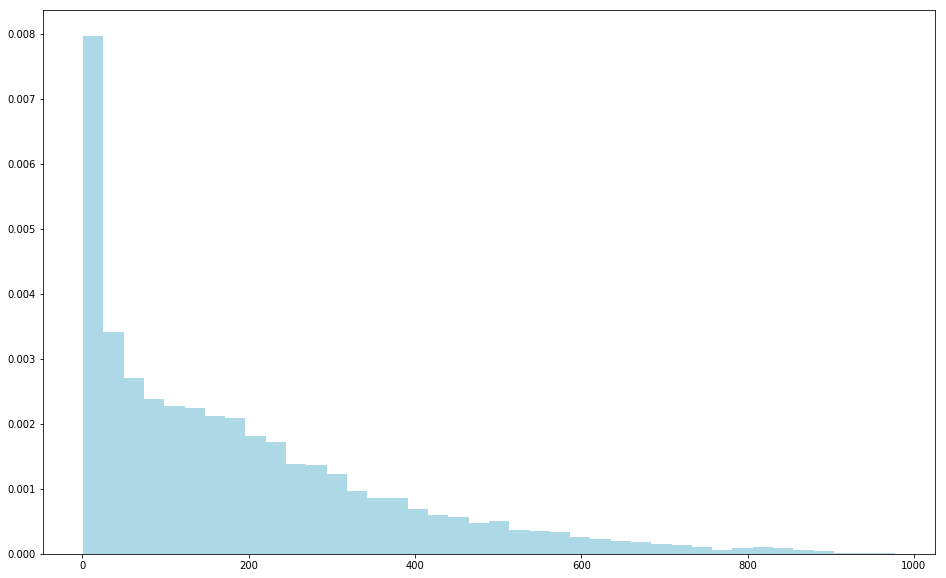

In [147]:
targets = records.map(lambda r: float(r[-1])).collect()

hist(targets, bins=40, color="lightblue", density=True)

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(16, 10)

# Looking at the histogram plot, 
# we can see that the distribution is highly skewed and 
# certainly does not follow a normal distribution:

# Figure 1: Distribution of raw target variable values

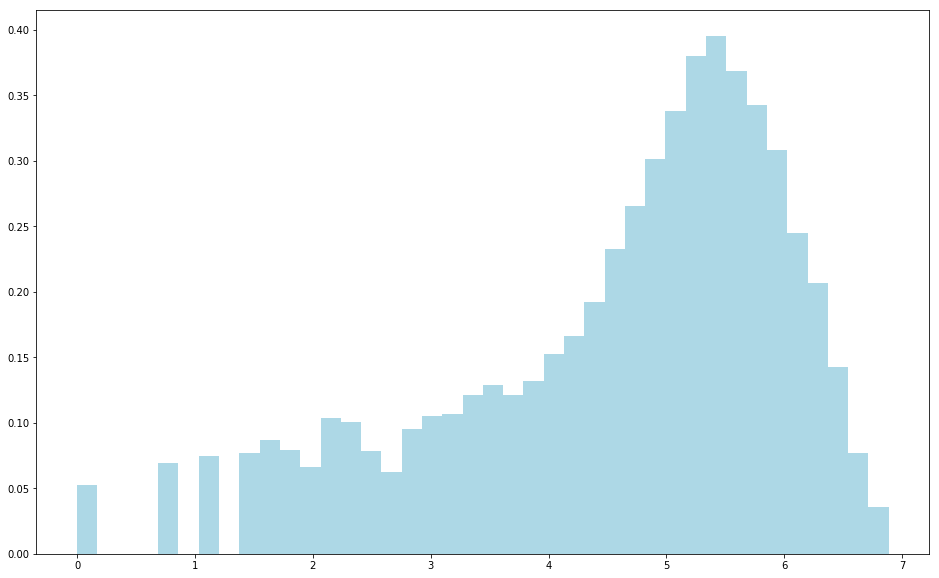

In [146]:
# As count cannot be negative during the prediction, 
# We take the logarithamic value of the target value
log_targets = records.map(lambda r: np.log(float(r[-1]))).collect()

hist(log_targets, bins=40, color="lightblue", density=True)

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(16, 10)
# Figure 2: Distribution of log-transformed target variable values


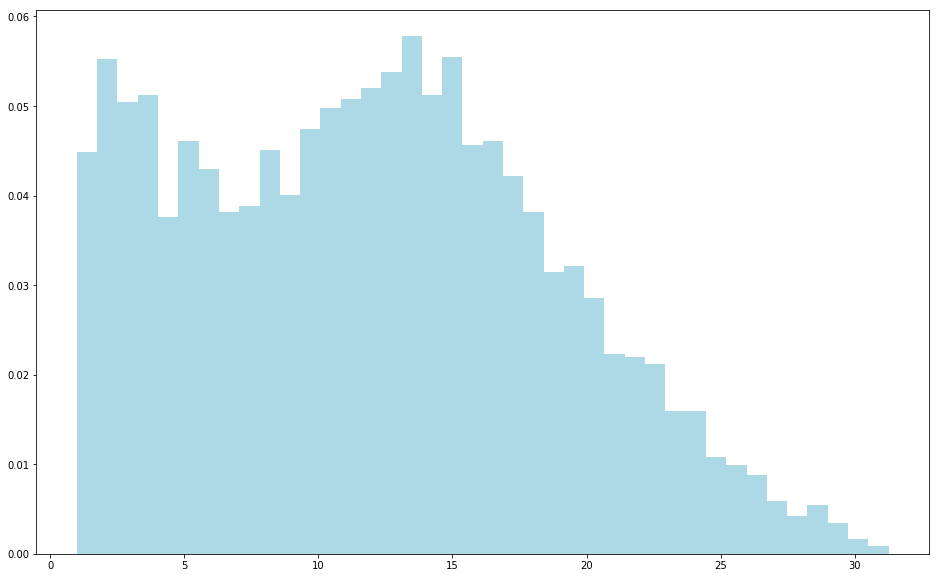

In [151]:
# Instead of logs, we can also take square roots of the target value, 
# to avoid the value to be negative.

sqrt_targets = records.map(lambda r: np.sqrt(float(r[-1]))).collect()

hist(sqrt_targets, bins=40, color="lightblue", density=True)

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(16, 10)

# Figure 3: Distribution of square-root-transformed target variable values

In [156]:
# 6.4 Impact of training on the log-transformed targets

data_log = data.map(lambda lp: LabeledPoint(np.log(lp.label), lp.features))

# We will then train a model on this transformed data and 
# form the RDD of predicted versus true values:

model_log = LinearRegressionWithSGD.train(data_log, iterations=10, step=0.1)

true_vs_predicted_log = data_log.map(lambda p: (np.exp(p.label), np.exp(model_log.predict(p.features))))

In [157]:
# Log transformed error prediction comparision with raw Data or non-log original data. 

mse_log = true_vs_predicted_log.map(lambda args: squared_error(args[0], args[1])).mean()

mae_log = true_vs_predicted_log.map(lambda args: abs_error(args[0], args[1])).mean()

rmsle_log = np.sqrt(true_vs_predicted_log.map(lambda args: squared_log_error(args[0], args[1])).mean())


print ("Mean Squared Error: %2.4f" % mse_log)

print ("Mean Absolue Error: %2.4f" % mae_log)

print ("Root Mean Squared Log Error: %2.4f" % rmsle_log)

print ("Non log-transformed predictions:\n " + str(true_vs_predicted.take(3)))

print ("Log-transformed predictions:\n" + str(true_vs_predicted_log.take(3)))

Mean Squared Error: 50685.5559
Mean Absolue Error: 155.2955
Root Mean Squared Log Error: 1.5411
Non log-transformed predictions:
 [(16.0, 117.89250386724845), (40.0, 116.22496123192113), (32.0, 116.02369145779235)]
Log-transformed predictions:
[(15.999999999999998, 28.080291845456223), (40.0, 26.959480191001774), (32.0, 26.65472562945802)]


In [158]:
## Similar log analysis for Decision tree

data_dt_log = data_dt.map(lambda lp: LabeledPoint(np.log(lp.label), lp.features))

dt_model_log = DecisionTree.trainRegressor(data_dt_log,{})

preds_log = dt_model_log.predict(data_dt_log.map(lambda p: p.features))

actual_log = data_dt_log.map(lambda p: p.label)

true_vs_predicted_dt_log = actual_log.zip(preds_log).map(lambda args: (np.exp(args[0]), np.exp(args[1])))




In [160]:
mse_log_dt = true_vs_predicted_dt_log.map(lambda args: squared_error(args[0], args[1])).mean()

mae_log_dt = true_vs_predicted_dt_log.map(lambda args: abs_error(args[0], args[1])).mean()

rmsle_log_dt = np.sqrt(true_vs_predicted_dt_log.map(lambda args: squared_log_error(args[0], args[1])).mean())

print ("Mean Squared Error: %2.4f" % mse_log_dt)

print ("Mean Absolue Error: %2.4f" % mae_log_dt)

print ("Root Mean Squared Log Error: %2.4f" % rmsle_log_dt)

print ("Non log-transformed predictions:\n" + str(true_vs_predicted_dt.take(3)))

print ("Log-transformed predictions:\n " + str(true_vs_predicted_dt_log.take(3)))

Mean Squared Error: 14781.5760
Mean Absolue Error: 76.4131
Root Mean Squared Log Error: 0.6406
Non log-transformed predictions:
[(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945)]
Log-transformed predictions:
 [(15.999999999999998, 37.53077978715451), (40.0, 37.53077978715451), (32.0, 7.279707099390729)]


In [173]:
## 6.5 Tuning model parameters

# first taking a random sample of, say, 20 percent of our data as our test

data_with_idx = data.zipWithIndex().map(lambda args: (args[1], args[0]))

test = data_with_idx.sample(False, 0.2, 42)

train = data_with_idx.subtractByKey(test)

train_data = train.map(lambda args: args[1])

test_data = test.map(lambda args: args[1])

train_size = train_data.count()

test_size = test_data.count()

print ("Training data size: %d" % train_size)

print ("Test data size: %d" % test_size)

print ("Total data size: %d " % (train_size + test_size))

print ("Train + Test size : %d" % (train_size + test_size))

Training data size: 13869
Test data size: 3510
Total data size: 17379 
Train + Test size : 17379


In [191]:
# Splitting the tree data also into training and testing

data_with_idx_dt = data_dt.zipWithIndex().map(lambda args: (args[1], args[0]))

test_dt = data_with_idx_dt.sample(False, 0.2, 42)

train_dt = data_with_idx_dt.subtractByKey(test_dt)

train_data_dt = train_dt.map(lambda args: args[1])

test_data_dt = test_dt.map(lambda args: args[1])

In [162]:
#7 Impact of parameter setting for linear models

# Evaluation function

def evaluate(train, test, iterations, step, regParam, regType, intercept):
    model = LinearRegressionWithSGD.train(
        train, iterations, step, regParam=regParam, 
        regType=regType, intercept=intercept
    )
    tp = test.map(lambda p: (p.label, model.predict(p.features)))
    rmsle = np.sqrt(tp.map(lambda args: squared_log_error(args[0], args[1])).mean())
    return rmsle

#rmsle is the root mean square linear error

In [176]:
# Comparision with diff iterations

params = [1, 5, 10, 20, 50, 100]

metrics = [evaluate(train_data, test_data, param, 0.01, 0.0, "l2", False) for param in params]

print (params)

print (metrics)

[1, 5, 10, 20, 50, 100]
[2.8895751840351522, 2.0389907666484954, 1.7689106650446305, 1.5672874678333346, 1.4112887844157065, 1.3708564590941776]


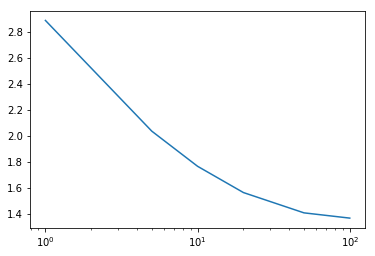

In [178]:
# Plotting RMSLE metric against number of iterations

plot(params, metrics)

fig = matplotlib.pyplot.gcf()

pyplot.xscale("log")

# Figure 4:Metrics for varying number of iterations

In [179]:
# 7.2 Performing same test, changing the step size. 

params = [0.01, 0.025, 0.05, 0.1, 1.0]

metrics = [evaluate(train_data, test_data, 10, param, 0.0, "l2", False) for param in params]

print (params)

print (metrics)

[0.01, 0.025, 0.05, 0.1, 1.0]
[1.7689106650446305, 1.4109119656546198, 1.37965777743331, 1.4580779096997896, nan]


/home/purnesh/spark-2.3.2-bin-hadoop2.7/python/pyspark/statcounter.py:80: RuntimeWarning: invalid value encountered in maximum
  self.maxValue = maximum(self.maxValue, other.maxValue)
/home/purnesh/spark-2.3.2-bin-hadoop2.7/python/pyspark/statcounter.py:81: RuntimeWarning: invalid value encountered in minimum
  self.minValue = minimum(self.minValue, other.minValue)


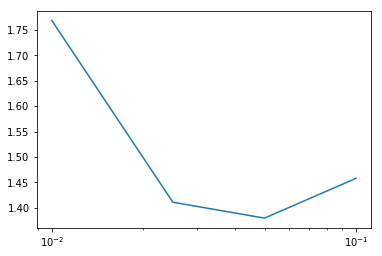

In [180]:
plot(params, metrics)

fig = matplotlib.pyplot.gcf()

pyplot.xscale("log")

# Figure 5:Metrics for varying values of step size

[0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
[1.4580779096997896, 1.4574329945186553, 1.4517403325137033, 1.4055537710502843, 1.3809678070431126, 1.5198891882336292, 1.8224536571417236]


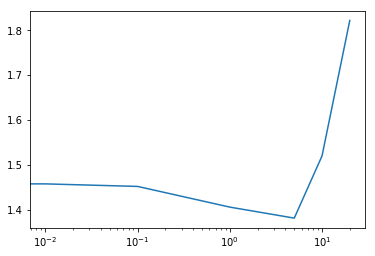

In [181]:
# 7.3 L2 Regularization

params = [0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]

metrics = [evaluate(train_data, test_data, 10, 0.1, param, "l2", False) for param in params]

print (params)

print (metrics)

plot(params, metrics)

fig = matplotlib.pyplot.gcf()

pyplot.xscale("log")

# Figure 6: Metrics for varying levels of L2 regularization

[0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
[1.4580779096997896, 1.458043054492044, 1.4577312609446176, 1.4548207151817398, 1.4279738870738146, 1.7425548127469217, 4.775096900108976]


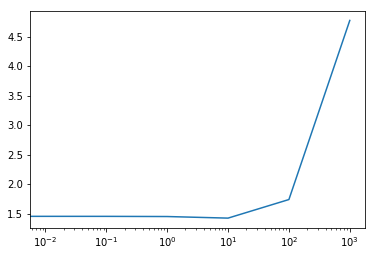

In [182]:
# 7.4 L1 Regularization

params = [0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

metrics = [evaluate(train_data, test_data, 10, 0.1, param, "l1", False) for param in params]

print (params)

print (metrics)

plot(params, metrics)

fig = matplotlib.pyplot.gcf()

pyplot.xscale("log")

# Figure 7: Metrics for varying levels of L1 regularization

In [184]:
# L1 Regularization using sparse weight vectors

model_l1 = LinearRegressionWithSGD.train(train_data, 10, 0.1, regParam=1.0, regType="l1", intercept=False)

model_l1_10 = LinearRegressionWithSGD.train(train_data, 10, 0.1, regParam=10.0, regType="l1", intercept=False)

model_l1_100 = LinearRegressionWithSGD.train(train_data, 10, 0.1, regParam=100.0, regType="l1", intercept=False)

print ("L1 (1.0) number of zero weights: " + str(sum(model_l1.weights.array == 0)))

print ("L1 (10.0) number of zeros weights: " + str(sum(model_l1_10.weights.array == 0)))

print ("L1 (100.0) number of zeros weights: " +str(sum(model_l1_100.weights.array == 0)))

L1 (1.0) number of zero weights: 5
L1 (10.0) number of zeros weights: 33
L1 (100.0) number of zeros weights: 58


[False, True]
[1.4055537710502843, 1.4363265851099394]


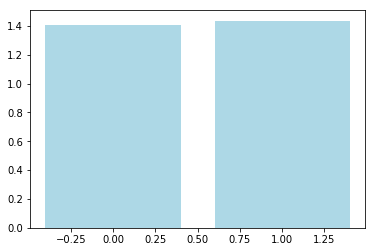

In [185]:
# 7.5 Intercept

params = [False, True]

metrics = [evaluate(train_data, test_data, 10, 0.1, 1.0, "l2", param) for param in params]

print (params)

print (metrics)

bar(params, metrics, color="lightblue")

fig = matplotlib.pyplot.gcf()

# Figure 8: Metrics without and with an intercept

In [189]:
# 8 The impact of parameter on Decision Tree

def evaluate_dt(train, test, maxDepth, maxBins):
    model = DecisionTree.trainRegressor(
        train, {}, impurity="variance", 
        maxDepth=maxDepth, 
        maxBins=maxBins
    )
    preds = model.predict(test.map(lambda p: p.features))
    actual = test.map(lambda p: p.label)
    tp = actual.zip(preds)
    rmsle = np.sqrt(tp.map(lambda args: squared_log_error(args[0], args[1])).mean())
    return rmsle


[1, 2, 3, 4, 5, 10, 20]
[1.0030410468296214, 0.9056056022124617, 0.8043230526513167, 0.7288878493078937, 0.6362063552427675, 0.43251136385116556, 0.45938487554067176]


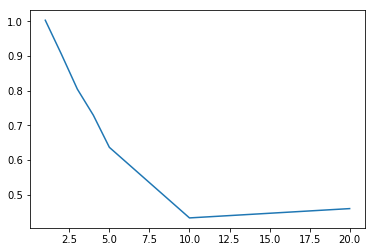

In [192]:
# 8.1 Tree Depth

params = [1, 2, 3, 4, 5, 10, 20]

metrics = [evaluate_dt(train_data_dt, test_data_dt, param, 32) for param in params]

print (params)

print (metrics)

plot(params, metrics)

fig = matplotlib.pyplot.gcf()

# Figure 9: Metrics for different tree depths

[2, 4, 8, 16, 32, 64, 100]
[1.2573502739272653, 0.8040386853025852, 0.7440397601011514, 0.6187627728845777, 0.6362063552427675, 0.6362063552427675, 0.6362063552427675]


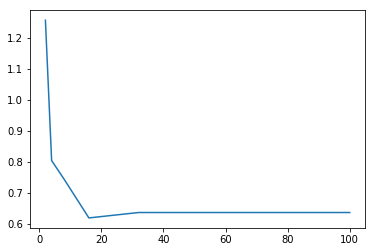

In [193]:
# 8.2 Maximum bins

params = [2, 4, 8, 16, 32, 64, 100]

metrics = [evaluate_dt(train_data_dt, test_data_dt, 5, param) for param in params]

print (params)

print (metrics)

plot(params, metrics)

fig = matplotlib.pyplot.gcf()

# Figure 10: Metrics for different maximum bins

In [204]:
train_data_dt.first().label

8.0

In [221]:
## Analysis for Gradient Boosted Tree

from pyspark.ml.classification import GBTClassifier


from pyspark.mllib.tree import GradientBoostedTrees

# Train a GBT model.
gbt_model = GradientBoostedTrees.trainRegressor(data_dt,categoricalFeaturesInfo={}, numIterations=3)

# model = GradientBoostedTrees.trainClassifier(trainingData,
#                                              categoricalFeaturesInfo={}, numIterations=3)

# # Evaluate model on test instances and compute test error
# predictions = model.predict(testData.map(lambda x: x.features))
# labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
# testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(testData.count())
# print('Test Error = ' + str(testErr))
# print('Learned classification GBT model:')
# print(model.toDebugString())


# dt_model = DecisionTree.trainRegressor(data_dt,{})

preds = gbt_model.predict(data_dt.map(lambda p: p.features))

actual = data.map(lambda p: p.label)

true_vs_predicted_gbt = actual.zip(preds)

print ("Gradient Boosted Tree predictions: " + str(true_vs_predicted_gbt.take(5)))

print ("Gradient Boosted Tree Tree depth: " + str(gbt_model.numTrees()))

print ("Gradient Boosted Tree number of nodes: " + str(gbt_model.totalNumNodes()))

## Error rates for Gradient Boosted Trees

mse_dt = true_vs_predicted_gbt.map(lambda args: squared_error(args[0], args[1])).mean()

mae_dt = true_vs_predicted_gbt.map(lambda args: abs_error(args[0], args[1])).mean()

rmsle_dt = np.sqrt(true_vs_predicted_gbt.map(lambda args: squared_log_error(args[0], args[1])).mean())

print ("Gradient Boosted Tree – Mean Squared Error: %2.4f" % mse_dt)

print ("Gradient Boosted Tree – Mean Absolute Error: %2.4f" % mae_dt)

print ("Gradient Boosted Tree – Root Mean Squared Log Error: %2.4f" % rmsle_dt)

Gradient Boosted Tree predictions: [(16.0, 46.167216204732135), (40.0, 46.167216204732135), (32.0, 17.808113781421504), (13.0, 17.808113781421504), (1.0, 17.808113781421504)]
Gradient Boosted Tree Tree depth: 3
Gradient Boosted Tree number of nodes: 45
Gradient Boosted Tree – Mean Squared Error: 13698.5518
Gradient Boosted Tree – Mean Absolute Error: 81.1557
Gradient Boosted Tree – Root Mean Squared Log Error: 0.7801


In [224]:
# Gradient boost tree iterations 
# 8 The impact of parameter on Gradient Boosted Tree

def evaluate_gradient_boosted_tree(train, test, maxDepth, maxBins):
    gbt_model = GradientBoostedTrees.trainRegressor(
        train, categoricalFeaturesInfo={},
        numIterations=2,
        maxDepth=maxDepth, maxBins=maxBins
    )
    preds = gbt_model.predict(test.map(lambda p: p.features))
    # preds = model.predict(test.map(lambda p: p.features))
    actual = test.map(lambda p: p.label)
    tp = actual.zip(preds)
    rmsle = np.sqrt(tp.map(lambda args: squared_log_error(args[0], args[1])).mean())
    return rmsle

In [218]:
# Varying Gradient Boosted Depth

params = [1, 2, 3, 4, 5, 10, 20]

metrics = [evaluate_gradient_boosted_tree(train_data_dt, test_data_dt, param, 32) for param in params]

print (params)

print (metrics)

plot(params, metrics)

fig = matplotlib.pyplot.gcf()

# Figure 11: Metrics for different tree depths

/home/purnesh/spark-2.3.2-bin-hadoop2.7/python/pyspark/statcounter.py:80: RuntimeWarning: invalid value encountered in maximum
  self.maxValue = maximum(self.maxValue, other.maxValue)
/home/purnesh/spark-2.3.2-bin-hadoop2.7/python/pyspark/statcounter.py:81: RuntimeWarning: invalid value encountered in minimum
  self.minValue = minimum(self.minValue, other.minValue)


KeyboardInterrupt: 

[2, 4, 8, 16, 32, 64, 100]
[1.2546358291693387, 0.7898569188061434, 0.7151755867170482, 0.5968974030023049, 0.6164627680928461, 0.6164627680928461, 0.6164627680928461]


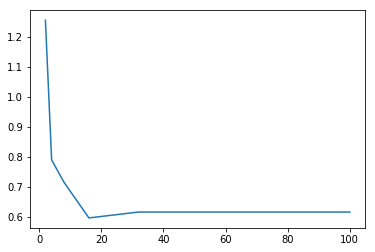

In [226]:
# Varying Gradient Boosted Tree Maximum bins

params = [2, 4, 8, 16, 32, 64, 100]

metrics = [evaluate_gradient_boosted_tree(train_data_dt, test_data_dt, 5, param) for param in params]

print (params)

print (metrics)

plot(params, metrics)

fig = matplotlib.pyplot.gcf()

# Figure 12: Metrics for different maximum bins